# Portfolio 3 - Clustering Visualisation

K-means clustering is one of the simplest and popular unsupervised learning algorithms. Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. This notebook illustrates the process of K-means clustering by generating some random clusters of data and then showing the iterations of the algorithm as random cluster means are updated. 

We first import the libraries that we are going to use. One of the most important for this particular portfolio is the sklearn.metrics. This in fact we enable us to calculate a distance between data points.

In [225]:
#importing appropriate libraries

import random
import numpy as np 
import seaborn as sns
import pandas as pd 
from sklearn.metrics import pairwise_distances_argmin
from matplotlib import pyplot as plt
from copy import deepcopy
%matplotlib inline

This following step shows the creation of the dataset. Points are randomly generated around some fixed centers

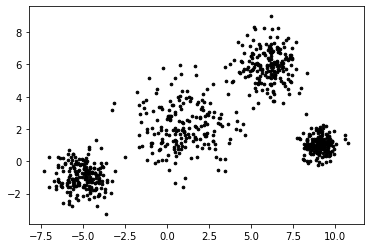

In [226]:
center_1 = np.array([1,2])
center_2 = np.array([6,6])
center_3 = np.array([9,1])
center_4 = np.array([-5,-1])

# Generate random data and center it to the four centers each with a different variance
np.random.seed(5)
data_1 = np.random.randn(200,2) * 1.5 + center_1
data_2 = np.random.randn(200,2) * 1 + center_2
data_3 = np.random.randn(200,2) * 0.5 + center_3
data_4 = np.random.randn(200,2) * 0.8 + center_4

data = np.concatenate((data_1, data_2, data_3, data_4), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7, c='k')
plt.show()

In [227]:
print("The datapoints generated are",data.shape[0],"and the dimensionality is " +str(data.shape[1])+"d")

The datapoints generated are 800 and the dimensionality is 2d


## 1. Generate random cluster centres

You need to generate four random centres.

This part of portfolio should contain at least:  
- The number of clusters `k` is set to 4;
- Generate random centres via `centres = np.random.randn(k,c)*std + mean` where `std` and `mean` are the standard deviation and mean of the data. `c` represents the number of features in the data. Set the random seed to 6.
- Color the generated centers with `green`, `blue`, `yellow`, and `cyan`. Set the edgecolors to `red`.

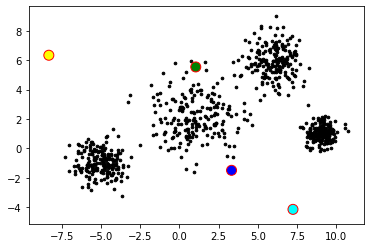

In [228]:
#Set the random seed to 6.
np.random.seed(6)
colmap = {0: "green", 1: "blue", 2: "yellow", 3: "cyan"}

k=4 #number of clusters

centers = np.random.randn(k,2)*data.std() +data.mean()
plt.scatter(data[:,0], data[:,1], s=7, c='k')
plt.scatter(centers[:, 0], centers[:, 1], c=['green','blue','yellow','cyan'], s=100,edgecolors='red');

The scatterplot above shows that the initial data centers are far away from the data points. In a larger dataset this may lead to some problem of convergence. Usually the initial data centers need to choosen in a smarter way than randomly. This in fact can speed up the algorithm. One famous algorithm that has been largely used is k-means ++ for using the initial values.

## 2. Visualise the clustering results in each iteration

You need to implement the process of k-means clustering.  Implement each iteration as a seperate cell, assigning each data point to the closest centre, then updating the cluster centres based on the data, then plot the new clusters.

First of all, k-means algorithm is quickly defined in the following rows.
The k-means algorithm can be divided into 3 different steps. In the first step, the algorithm arbitrarily selects K data points to be the seeds. The next step gives each record to the closest seed. In other words, the algorithm measures the Euclidian distance of each row to each seed and chooses the minimum distance for this step. The final step computes the centroids of the clusters. The centroids will then be the seeds for the next iteration of the algorithm. Each step is repeated until the cluster boundaries stop changing.

This method sorts the items according to how alike and dislike they are to the other clusters.

In order to facilitate a future algorithm, a dictionary will keep record of the centroids (seeds) while all the data points will be stored into a dataframe.

In [229]:
#Arranging the random centers into a dictionary
centroids = dict()
for i in range(len(centers)):
    centroids[i] = [centers[i][0], centers[i][1]]

#creating a dataframe with all the datapoints
df = pd.DataFrame(data, columns = ["x","y"])

Below there is a function that aim to allocate each datapoint to the closest centroid.

In [230]:
def allocation(df, centroids):
    '''this function has the initial dataframe and centroids as input and return 
       a dataframe where each point is allocate'''
    for i in centroids.keys():
       
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2
                + (df['y'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

df = allocation(df, centroids)

Let us see what the first iteration of the algorithm has produce by examining the first datapoints and their distance with the initial centroids. Notice that here we have not updated the data centers yet.

In [231]:
print(df.head())

          x         y  distance_from_0  distance_from_1  distance_from_2  \
0  1.661841  1.503695         4.082119         3.430732        11.117939   
1  4.646157  1.621862         5.322005         3.382036        13.825861   
2  1.164415  4.373722         1.171223         6.254640         9.716070   
3 -0.363849  1.112545         4.644304         4.521306         9.543335   
4  1.281405  1.505195         4.040480         3.632268        10.775887   

   distance_from_3  closest  color  
0         7.955179        1   blue  
1         6.335582        1   blue  
2        10.478115        0  green  
3         9.262315        1   blue  
4         8.228278        1   blue  


According to the table above, the first data point (id=0) has been assigned to blue because that point is closest with the blue centroid. By looking at the scatterplot above this point seems like in the middle between the green and blue centroid. The algorithm helps us to quantify those distances and assign each point properly.

We can consider this as the first iteration. Let see a scatterplot to see how each datapoint have been assigned

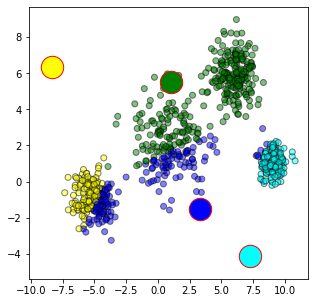

In [232]:
#SCATTERPLOT OF THE POINTS AND CENTROIDS
fig = plt.figure(figsize=(5, 5))
plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i], edgecolor = "r", s = 500)

plt.show()

The scatterplot above shows how the datapoints are allocate after the first iteration. We can clearly see how "badly" it performed. In fact there is no clear separation between the groups.

The next step of the algorithm is to update the centroids and reallocate the point again given the new updated centroids. In this step, the centroids are recomputed. This is done by taking the mean of all data points assigned to that centroid's cluster.

In [233]:
import copy

#CREATE A COPY OF THE OLDEST VERSION OF CENTROIDS
old_centroids = copy.deepcopy(centroids)

def update(centers):
    '''the function accepts the oldest centers
       and return the new centers'''
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['y'])
    return centers
#UPDATE THE CENTROIDS AND CALL THE FUNCTION ALLOCATION AGAIN 
centroids = update(centroids)
df = allocation(df, centroids)
print(df.head())

          x         y  distance_from_0  distance_from_1  distance_from_2  \
0  1.661841  1.503695         4.055615         3.201406         7.528648   
1  4.646157  1.621862         3.263641         5.994233        10.445361   
2  1.164415  4.373722         2.866763         5.047836         8.401766   
3 -0.363849  1.112545         5.723310         1.449582         5.481129   
4  1.281405  1.505195         4.284734         2.882996         7.166030   

   distance_from_3  closest  color  
0         7.447981        1   blue  
1         4.488340        0  green  
2         8.609074        0  green  
3         9.458509        1   blue  
4         7.827752        1   blue  


We can see from the table above that actually one datapoint has been moved in a different group compering the first iteriation. In fact, (id=1) was in the blue group but after the second iteration it had been moved to the green group.

Let us see now the graphical display of the datapoints after the second iteration.

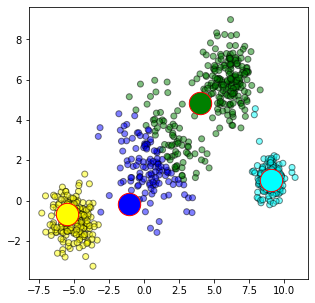

In [234]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i], edgecolor = "r", s = 500)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
plt.show()

After the second iteration we can see that the situation has improved. The yellow, cyan and green points are well separeted comparing to the rest. However, the central part of the graph shows still some data points that are not well separated.

The algorithm will still run until there is no difference between the centroids in two consecutive iterations. 

In [235]:
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
print(centroids == old_centroids)

False


False indicates that the algorithm still can be run. in fact there is still a big difference betweenn the old_centroids and new centroids. The process will end up when True will be print and therefore no datapoints can move.

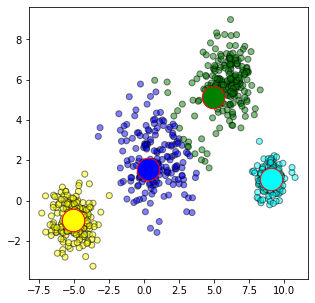

False


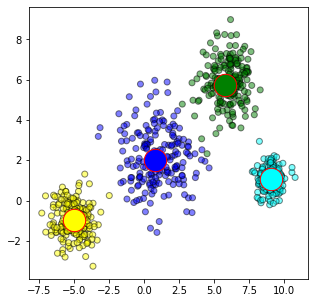

False


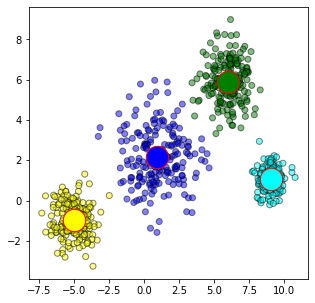

False


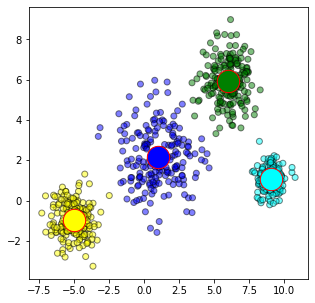

False


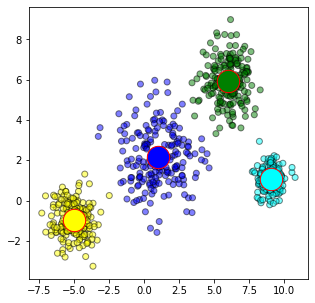

True


In [222]:
count=2
while(centroids != old_centroids):
    old_centroids = copy.deepcopy(centroids)
    centroids = update(centroids)
    df = allocation(df, centroids)

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes()
    plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
    for i in centroids.keys():
        plt.scatter(*centroids[i], color=colmap[i], edgecolor = "r", s = 500)
    for i in old_centroids.keys():
        old_x = old_centroids[i][0]
        old_y = old_centroids[i][1]
        dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
        dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    plt.show()
    print(centroids == old_centroids)
    count=count+1

In [223]:
print('The total number of iterations are',count)

The total number of iterations are 7


## CONCLUSION

This portfolio illustrate the k-means algorithm without using any built-in class. The scope was dividing the data points into a number of groups such that data points in the same groups are more similar to other data points in the same group than those in other groups. 

In other words, the goal is to segregate groups with similar traits and assign them into clusters.

The number of iteration needed was 7.

# REFERENCES

K-means Clustering in Python,Ben Alex Keen : http://benalexkeen.com/k-means-clustering-in-python/